In [3]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# DEFINE CUNY CAMPUSES AND NEIGHBORHOOD INFORMATION
cuny_campuses = {
    '4-year': {
        'Baruch College': {
            'location': (40.7401, -73.9838),
            'subway_stations': ['23 St', 'Lexington Av/63 St'],
            'bus_routes': ['M1', 'M2', 'M3', 'M15', 'M101']
        },
        'Hunter College': {
            'location': (40.7686, -73.9648),
            'subway_stations': ['68 St-Hunter College', '77 St'],
            'bus_routes': ['M15', 'M66', 'M72', 'M98', 'M101', 'M102', 'M103']
        },
        'City College': {
            'location': (40.8200, -73.9493),
            'subway_stations': ['137 St-City College', '145 St'],
            'bus_routes': ['M3', 'M4', 'M5', 'M100', 'M101', 'Bx33']
        }
    },
    '2-year': {
        'BMCC': {
            'location': (40.7182, -74.0132),
            'subway_stations': ['Chambers St', 'Park Place'],
            'bus_routes': ['M20', 'M22', 'M9']
        },
        'LaGuardia CC': {
            'location': (40.7441, -73.9345),
            'subway_stations': ['33 St-Rawson St', '40 St-Lowery St'],
            'bus_routes': ['Q39', 'Q60', 'Q67']
        },
        'Hostos CC': {
            'location': (40.8181, -73.9279),
            'subway_stations': ['149 St-Grand Concourse', '3 Av-149 St'],
            'bus_routes': ['Bx1', 'Bx2', 'Bx19']
        }
    }
}

target_neighborhoods = {
    'Elmhurst/Jackson Heights': {
        'subway_stations': ['74-Broadway (7)', 'Jackson Hts-Roosevelt Av', 'Elmhurst Av'],
        'bus_routes': ['Q32', 'Q33', 'Q47', 'Q49', 'Q53+', 'Q70+']
    },
    'Flushing': {
        'subway_stations': ['Flushing-Main St', 'Mets-Willets Point'],
        'bus_routes': ['Q12', 'Q13', 'Q15', 'Q16', 'Q17', 'Q19', 'Q20A', 'Q20B', 'Q44+', 'Q48']
    },
    'Sunset Park': {
        'subway_stations': ['36 St', '45 St', '53 St', '59 St', '8 Av'],
        'bus_routes': ['B11', 'B35', 'B37', 'B63', 'B70']
    },
    'Brownsville': {
        'subway_stations': ['Sutter Av-Rutland Rd', 'Saratoga Av', 'Rockaway Av'],
        'bus_routes': ['B14', 'B15', 'B20', 'B60', 'B82+']
    },
    'Morrisania': {
        'subway_stations': ['167 St', '170 St', 'Freeman St'],
        'bus_routes': ['BX11', 'BX15', 'BX21', 'BX35', 'BX41']
    },
    'Highbridge': {
        'subway_stations': ['170 St', '167 St', '161 St-Yankee Stadium'],
        'bus_routes': ['BX13', 'BX35', 'BX1', 'BX2']
    }
}

INITIALIZING FAIR FARES NETWORK ANALYSIS...
LOADING TRANSIT DATA...
LOADED 66,760,770 SUBWAY RECORDS AND 54,589,317 BUS RECORDS
SETTING UP DATABASE...
CREATING INDICES...
RUNNING NETWORK ANALYSIS...
ANALYZING STATION NETWORK PATTERNS...

VISUALIZING RESULTS...


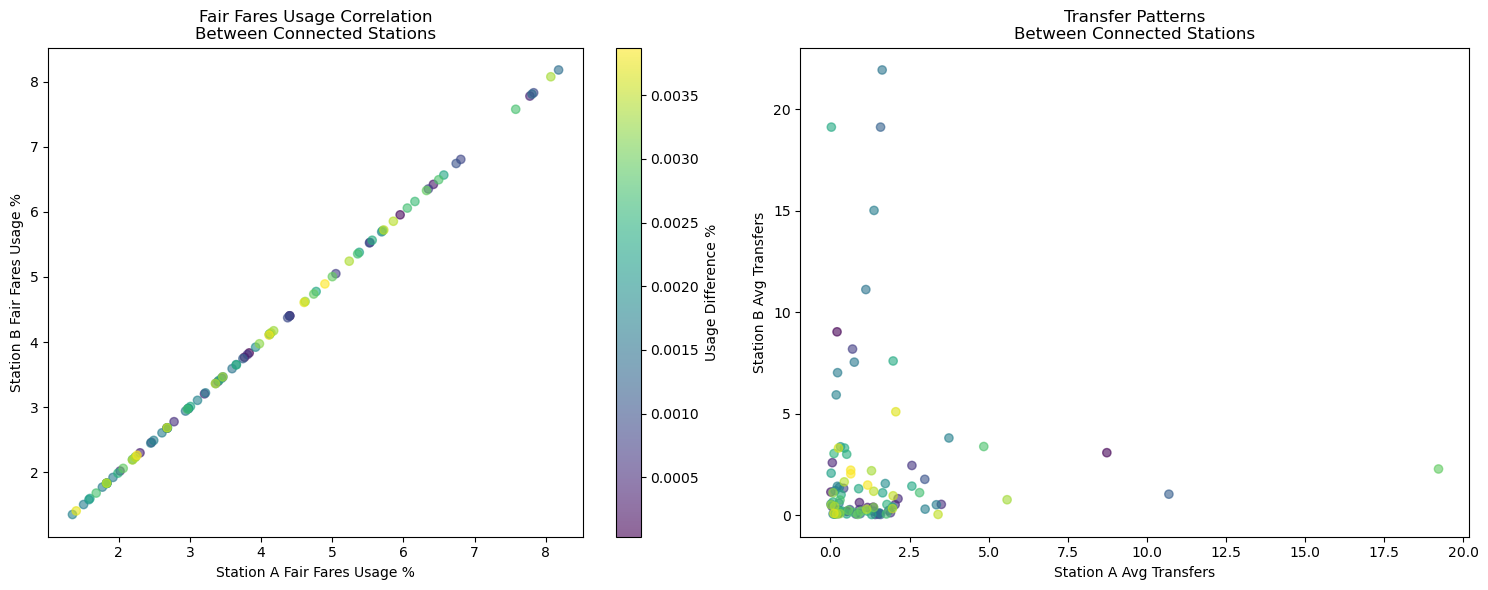


KEY NETWORK INSIGHTS:

MOST SIMILAR STATIONS IN FAIR FARES USAGE:

Sterling St (2,5) ↔️ Woodhaven Blvd (M,R):
- Usage: 3.8% vs 3.8%
- Transfers: 0.21 vs 9.03

Grand Av-Newtown (M,R) ↔️ Ozone Park-Lefferts Blvd (A):
- Usage: 3.8% vs 3.8%
- Transfers: 8.73 vs 3.07

116 St (6) ↔️ Saratoga Av (3):
- Usage: 6.0% vs 6.0%
- Transfers: 1.35 vs 0.39

Beach 25 St (A) ↔️ Bedford Park Blvd (B,D):
- Usage: 6.4% vs 6.4%
- Transfers: 0.01 vs 1.13

Avenue M (Q) ↔️ Avenue N (F):
- Usage: 4.4% vs 4.4%
- Transfers: 0.92 vs 0.61


In [4]:
# CREATE NETWORK ANALYSIS CLASS FOR BETTER ORGANIZATION
import os

class FairFaresNetworkAnalysis:
    def __init__(self, data_path='../data/processed/'):
        self.data_path = data_path
        self.conn = None
        
    def load_data(self):
        """
        Loads subway and bus data efficiently
        """
        print("LOADING TRANSIT DATA...")
        self.subway_df = pd.read_csv(f'{self.data_path}subway_cleaned.csv', low_memory=False)
        self.bus_df = pd.read_csv(f'{self.data_path}bus_cleaned.csv', low_memory=False)
        
        # CONVERT TIMESTAMP TO DATETIME
        self.subway_df['transit_timestamp'] = pd.to_datetime(self.subway_df['transit_timestamp'])
        self.bus_df['transit_timestamp'] = pd.to_datetime(self.bus_df['transit_timestamp'])
        
        print(f"LOADED {len(self.subway_df):,} SUBWAY RECORDS AND {len(self.bus_df):,} BUS RECORDS")
    
    def setup_database(self):
        """
        Creates SQL database with optimized indices
        """
        print("SETTING UP DATABASE...")
        self.conn = sqlite3.connect(':memory:')  # Using memory for speed
        
        # CREATE OPTIMIZED TABLES
        self.subway_df.to_sql('subway_rides', self.conn, index=False, 
                            if_exists='replace',
                            method='multi',  # Faster insertion
                            chunksize=10000)
        
        # CREATE INDICES FOR FASTER QUERIES
        print("CREATING INDICES...")
        self.conn.execute("CREATE INDEX idx_station ON subway_rides(station_complex)")
        self.conn.execute("CREATE INDEX idx_timestamp ON subway_rides(transit_timestamp)")
        self.conn.execute("CREATE INDEX idx_fare ON subway_rides(fare_class_category)")
    
    def analyze_station_network(self):
        """
        Analyzes how stations are connected through Fair Fares usage
        """
        print("ANALYZING STATION NETWORK PATTERNS...")
        
        network_query = """
        WITH station_metrics AS (
            SELECT 
                station_complex,
                COUNT(*) as total_records,
                SUM(ridership) as total_ridership,
                SUM(CASE WHEN fare_class_category LIKE '%Fair Fare%' 
                    THEN ridership ELSE 0 END) as fair_fares_rides,
                AVG(transfers) as avg_transfers
            FROM subway_rides
            GROUP BY station_complex
        )
        SELECT 
            s1.station_complex as station_a,
            s2.station_complex as station_b,
            s1.fair_fares_rides * 100.0 / s1.total_ridership as station_a_ff_pct,
            s2.fair_fares_rides * 100.0 / s2.total_ridership as station_b_ff_pct,
            s1.avg_transfers as station_a_transfers,
            s2.avg_transfers as station_b_transfers,
            ABS(s1.fair_fares_rides * 100.0 / s1.total_ridership - 
                s2.fair_fares_rides * 100.0 / s2.total_ridership) as usage_difference
        FROM station_metrics s1
        JOIN station_metrics s2 
            ON s1.station_complex < s2.station_complex
        WHERE s1.total_ridership > 10000 
            AND s2.total_ridership > 10000
        ORDER BY usage_difference
        LIMIT 100
        """
        
        return pd.read_sql_query(network_query, self.conn)
    
    def visualize_network(self, network_df):
        """
        Creates visualizations of network patterns
        """
        plt.figure(figsize=(15, 6))
        
        # PLOT 1: FAIR FARES USAGE CORRELATION
        plt.subplot(1, 2, 1)
        plt.scatter(network_df['station_a_ff_pct'], 
                   network_df['station_b_ff_pct'],
                   alpha=0.6,
                   c=network_df['usage_difference'],
                   cmap='viridis')
        plt.xlabel('Station A Fair Fares Usage %')
        plt.ylabel('Station B Fair Fares Usage %')
        plt.title('Fair Fares Usage Correlation\nBetween Connected Stations')
        plt.colorbar(label='Usage Difference %')
        
        # PLOT 2: TRANSFER PATTERNS
        plt.subplot(1, 2, 2)
        plt.scatter(network_df['station_a_transfers'],
                   network_df['station_b_transfers'],
                   alpha=0.6,
                   c=network_df['usage_difference'],
                   cmap='viridis')
        plt.xlabel('Station A Avg Transfers')
        plt.ylabel('Station B Avg Transfers')
        plt.title('Transfer Patterns\nBetween Connected Stations')
        
        plt.tight_layout()
        plt.show()

# RUN THE ANALYSIS
try:
    print("INITIALIZING FAIR FARES NETWORK ANALYSIS...")
    analyzer = FairFaresNetworkAnalysis()
    
    analyzer.load_data()
    analyzer.setup_database()
    
    print("RUNNING NETWORK ANALYSIS...")
    network_results = analyzer.analyze_station_network()
    
    print("\nVISUALIZING RESULTS...")
    analyzer.visualize_network(network_results)
    
    # PRINT KEY FINDINGS
    print("\nKEY NETWORK INSIGHTS:")
    print("=" * 50)
    
    # FIND MOST SIMILAR STATIONS IN FAIR FARES USAGE
    similar_stations = network_results.nsmallest(5, 'usage_difference')
    print("\nMOST SIMILAR STATIONS IN FAIR FARES USAGE:")
    for _, row in similar_stations.iterrows():
        print(f"\n{row['station_a']} ↔️ {row['station_b']}:")
        print(f"- Usage: {row['station_a_ff_pct']:.1f}% vs {row['station_b_ff_pct']:.1f}%")
        print(f"- Transfers: {row['station_a_transfers']:.2f} vs {row['station_b_transfers']:.2f}")
    
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

INITIALIZING TIME SERIES ANALYSIS...
LOADING AND PREPARING DATA...


C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2306107416.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2306107416.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2306107416.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2306107416.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Lo

PROCESSED 32,804 TIME PERIODS

ANALYZING TEMPORAL PATTERNS...

VISUALIZING PATTERNS...


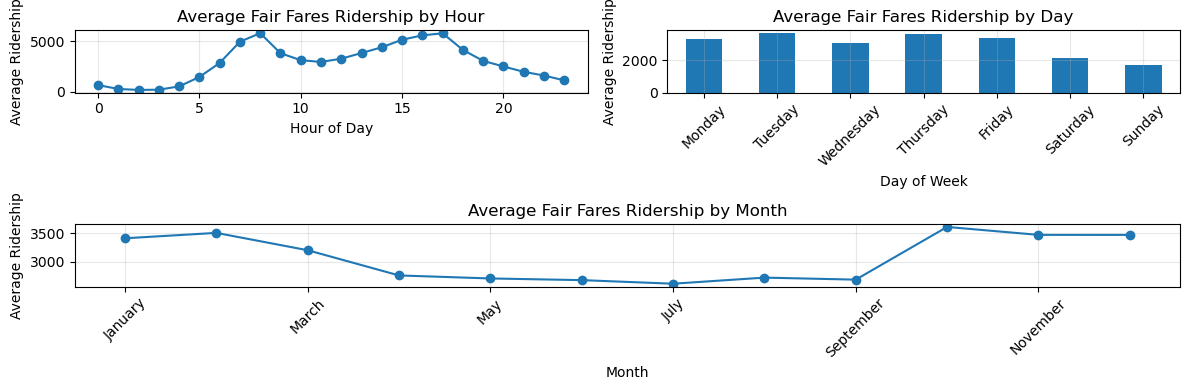


IDENTIFYING KEY PATTERNS:

PEAK USAGE TIMES:
- Hour: 08:00
- Day: Tuesday
- Month: October

USAGE RATIOS:
- Weekday/Weekend: 1.77
- Peak Hour Multiplier: 2.00x


In [5]:
# CREATE TIME-SERIES ANALYSIS

class FairFaresTimeAnalysis:
    def __init__(self):
        # USE IN-MEMORY DATABASE FOR FASTER PROCESSING
        self.conn = sqlite3.connect(':memory:')
        
    def load_and_prepare_data(self, chunk_size=500000):
        """
        Loads data in chunks and prepares it for time series analysis
        """
        print("LOADING AND PREPARING DATA...")
        
        # READ DATA IN CHUNKS
        chunks = []
        for chunk in pd.read_csv('../data/processed/subway_cleaned.csv', 
                               chunksize=chunk_size):
            # FILTER FOR FAIR FARES USAGE
            fair_fares_data = chunk[
                chunk['fare_class_category'].str.contains('Fair Fare', na=False)
            ]
            
            # AGGREGATE BY TIMESTAMP
            chunk_agg = fair_fares_data.groupby('transit_timestamp').agg({
                'ridership': 'sum',
                'transfers': 'mean'
            }).reset_index()
            
            chunks.append(chunk_agg)
        
        # COMBINE CHUNKS
        self.time_data = pd.concat(chunks)
        self.time_data['transit_timestamp'] = pd.to_datetime(
            self.time_data['transit_timestamp']
        )
        
        print(f"PROCESSED {len(self.time_data):,} TIME PERIODS")
    
    def analyze_temporal_patterns(self):
        """
        Analyzes various time-based patterns in Fair Fares usage
        """
        # ADD TIME COMPONENTS
        self.time_data['hour'] = self.time_data['transit_timestamp'].dt.hour
        self.time_data['day_of_week'] = self.time_data['transit_timestamp'].dt.day_name()
        self.time_data['month'] = self.time_data['transit_timestamp'].dt.month_name()
        
        # CALCULATE HOURLY PATTERNS
        hourly_patterns = self.time_data.groupby('hour')['ridership'].mean()
        
        # CALCULATE DAILY PATTERNS
        daily_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                      'Friday', 'Saturday', 'Sunday']
        daily_patterns = self.time_data.groupby('day_of_week')['ridership'].mean()
        daily_patterns = daily_patterns.reindex(daily_order)
        
        # CALCULATE MONTHLY PATTERNS
        monthly_order = ['January', 'February', 'March', 'April', 'May', 'June',
                        'July', 'August', 'September', 'October', 'November', 'December']
        monthly_patterns = self.time_data.groupby('month')['ridership'].mean()
        monthly_patterns = monthly_patterns.reindex(monthly_order)
        
        return hourly_patterns, daily_patterns, monthly_patterns
    
    def visualize_patterns(self, hourly, daily, monthly):
        """
        Creates visualizations of temporal patterns
        """
        plt.figure(figsize=(15, 10))
        
        # PLOT HOURLY PATTERNS
        plt.subplot(2, 2, 1)
        hourly.plot(kind='line', marker='o')
        plt.title('Average Fair Fares Ridership by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Ridership')
        plt.grid(True, alpha=0.3)
        
        # PLOT DAILY PATTERNS
        plt.subplot(2, 2, 2)
        daily.plot(kind='bar')
        plt.title('Average Fair Fares Ridership by Day')
        plt.xlabel('Day of Week')
        plt.ylabel('Average Ridership')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # PLOT MONTHLY PATTERNS
        plt.subplot(2, 1, 2)
        monthly.plot(kind='line', marker='o', figsize=(12, 4))
        plt.title('Average Fair Fares Ridership by Month')
        plt.xlabel('Month')
        plt.ylabel('Average Ridership')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def identify_peak_periods(self, hourly, daily, monthly):
        """
        Identifies key usage patterns and peak periods
        """
        # FIND PEAK TIMES
        peak_hour = hourly.idxmax()
        peak_day = daily.idxmax()
        peak_month = monthly.idxmax()
        
        # CALCULATE USAGE RATIOS
        weekday_avg = daily[daily.index.isin(['Monday', 'Tuesday', 'Wednesday', 
                                            'Thursday', 'Friday'])].mean()
        weekend_avg = daily[daily.index.isin(['Saturday', 'Sunday'])].mean()
        weekday_weekend_ratio = weekday_avg / weekend_avg
        
        return {
            'peak_times': {
                'hour': peak_hour,
                'day': peak_day,
                'month': peak_month
            },
            'usage_ratios': {
                'weekday_weekend': weekday_weekend_ratio,
                'peak_hour_multiplier': hourly.max() / hourly.mean()
            }
        }

# RUN THE ANALYSIS
try:
    print("INITIALIZING TIME SERIES ANALYSIS...")
    analyzer = FairFaresTimeAnalysis()
    
    analyzer.load_and_prepare_data()
    
    print("\nANALYZING TEMPORAL PATTERNS...")
    hourly_patterns, daily_patterns, monthly_patterns = analyzer.analyze_temporal_patterns()
    
    print("\nVISUALIZING PATTERNS...")
    analyzer.visualize_patterns(hourly_patterns, daily_patterns, monthly_patterns)
    
    print("\nIDENTIFYING KEY PATTERNS:")
    print("=" * 50)
    patterns = analyzer.identify_peak_periods(hourly_patterns, daily_patterns, 
                                           monthly_patterns)
    
    print(f"\nPEAK USAGE TIMES:")
    print(f"- Hour: {patterns['peak_times']['hour']:02d}:00")
    print(f"- Day: {patterns['peak_times']['day']}")
    print(f"- Month: {patterns['peak_times']['month']}")
    
    print(f"\nUSAGE RATIOS:")
    print(f"- Weekday/Weekend: {patterns['usage_ratios']['weekday_weekend']:.2f}")
    print(f"- Peak Hour Multiplier: {patterns['usage_ratios']['peak_hour_multiplier']:.2f}x")
    
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

INITIALIZING CROSS-SYSTEM ANALYSIS...
LOADING TRANSIT DATA...


C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2943911345.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2943911345.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2943911345.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2943911345.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('../data/processed/subway_cleaned.csv',
C:\Users\mabdulsamad_\AppData\Lo

LOADED 10,207,831 SUBWAY RECORDS AND 8,238,118 BUS RECORDS

ANALYZING SYSTEM INTEGRATION...

VISUALIZING INTEGRATION PATTERNS...


C:\Users\mabdulsamad_\AppData\Local\Temp\ipykernel_20016\2943911345.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


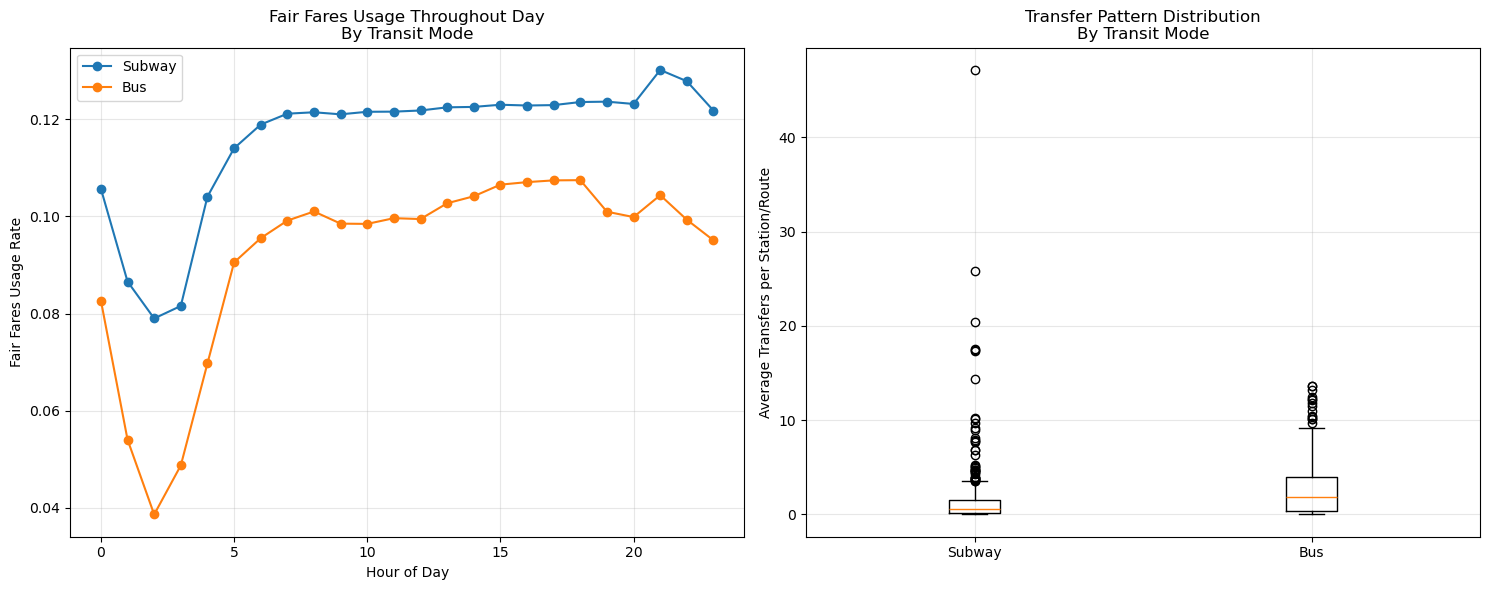


KEY INTEGRATION METRICS:

PEAK USAGE TIMES:
- Subway Peak: 21:00
- Bus Peak: 18:00
- Time Difference: 3 hours

SYSTEM CORRELATION:
- Usage Pattern Correlation: 0.98

TRANSFER PATTERNS:
- Subway Average: 1.53
- Bus Average: 2.63
- Maximum Subway: 47.13
- Maximum Bus: 13.64


In [6]:
# CROSS-SYSTEM INTEGRATION ANALYSIS
class FairFaresCrossSystemAnalysis:
    """
    Analyzes how Fair Fares usage patterns integrate between subway and bus systems,
    identifying connection points and usage relationships.
    """
    def __init__(self):
        # INITIALIZE IN-MEMORY DATABASE FOR EFFICIENT PROCESSING
        self.conn = sqlite3.connect(':memory:')
        
    def load_integrated_data(self, chunk_size=500000):
        """
        Loads and integrates subway and bus data efficiently using chunked processing
        """
        print("LOADING TRANSIT DATA...")
        
        # PROCESS SUBWAY DATA IN CHUNKS
        subway_chunks = []
        for chunk in pd.read_csv('../data/processed/subway_cleaned.csv', 
                               chunksize=chunk_size):
            # PREPARE SUBWAY DATA
            subway_agg = chunk.groupby(['transit_timestamp', 'station_complex']).agg({
                'ridership': 'sum',
                'transfers': 'mean',
                'fare_class_category': lambda x: (
                    x.str.contains('Fair Fare').mean()
                )
            }).reset_index()
            subway_chunks.append(subway_agg)
        
        # PROCESS BUS DATA IN CHUNKS
        bus_chunks = []
        for chunk in pd.read_csv('../data/processed/bus_cleaned.csv', 
                               chunksize=chunk_size):
            # PREPARE BUS DATA
            bus_agg = chunk.groupby(['transit_timestamp', 'bus_route']).agg({
                'ridership': 'sum',
                'transfers': 'mean',
                'fare_class_category': lambda x: (
                    x.str.contains('Fair Fare').mean()
                )
            }).reset_index()
            bus_chunks.append(bus_agg)
        
        # COMBINE ALL DATA
        self.subway_data = pd.concat(subway_chunks)
        self.bus_data = pd.concat(bus_chunks)
        
        # CONVERT TIMESTAMPS
        self.subway_data['transit_timestamp'] = pd.to_datetime(
            self.subway_data['transit_timestamp']
        )
        self.bus_data['transit_timestamp'] = pd.to_datetime(
            self.bus_data['transit_timestamp']
        )
        
        print(f"LOADED {len(self.subway_data):,} SUBWAY RECORDS AND {len(self.bus_data):,} BUS RECORDS")
    
    def analyze_modal_integration(self):
        """
        Analyzes how Fair Fares users integrate subway and bus usage
        """
        # ANALYZE HOURLY PATTERNS BY MODE
        subway_hourly = self.subway_data.groupby(
            self.subway_data['transit_timestamp'].dt.hour
        )['fare_class_category'].mean()
        
        bus_hourly = self.bus_data.groupby(
            self.bus_data['transit_timestamp'].dt.hour
        )['fare_class_category'].mean()
        
        # ANALYZE TRANSFER PATTERNS
        subway_transfers = self.subway_data.groupby('station_complex')['transfers'].mean()
        bus_transfers = self.bus_data.groupby('bus_route')['transfers'].mean()
        
        return {
            'hourly_patterns': {
                'subway': subway_hourly,
                'bus': bus_hourly
            },
            'transfer_patterns': {
                'subway': subway_transfers,
                'bus': bus_transfers
            }
        }
    
    def visualize_integration(self, integration_data):
        """
        Creates visualizations showing how the two systems integrate
        """
        plt.figure(figsize=(15, 6))
        
        # PLOT HOURLY FAIR FARES USAGE BY MODE
        plt.subplot(1, 2, 1)
        integration_data['hourly_patterns']['subway'].plot(
            label='Subway', marker='o'
        )
        integration_data['hourly_patterns']['bus'].plot(
            label='Bus', marker='o'
        )
        plt.title('Fair Fares Usage Throughout Day\nBy Transit Mode')
        plt.xlabel('Hour of Day')
        plt.ylabel('Fair Fares Usage Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # PLOT TRANSFER DISTRIBUTIONS
        plt.subplot(1, 2, 2)
        plt.boxplot([
            integration_data['transfer_patterns']['subway'],
            integration_data['transfer_patterns']['bus']
        ], labels=['Subway', 'Bus'])
        plt.title('Transfer Pattern Distribution\nBy Transit Mode')
        plt.ylabel('Average Transfers per Station/Route')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def calculate_integration_metrics(self, integration_data):
        """
        Calculates key metrics about system integration
        """
        subway_patterns = integration_data['hourly_patterns']['subway']
        bus_patterns = integration_data['hourly_patterns']['bus']
        
        # CALCULATE PEAK USAGE OVERLAP
        subway_peak = subway_patterns.idxmax()
        bus_peak = bus_patterns.idxmax()
        
        # CALCULATE USAGE CORRELATION
        correlation = subway_patterns.corr(bus_patterns)
        
        # CALCULATE TRANSFER METRICS
        subway_transfers = integration_data['transfer_patterns']['subway']
        bus_transfers = integration_data['transfer_patterns']['bus']
        
        return {
            'peak_times': {
                'subway': subway_peak,
                'bus': bus_peak,
                'difference': abs(subway_peak - bus_peak)
            },
            'correlation': correlation,
            'transfer_metrics': {
                'subway_avg': subway_transfers.mean(),
                'bus_avg': bus_transfers.mean(),
                'subway_max': subway_transfers.max(),
                'bus_max': bus_transfers.max()
            }
        }

# RUN THE ANALYSIS
try:
    print("INITIALIZING CROSS-SYSTEM ANALYSIS...")
    analyzer = FairFaresCrossSystemAnalysis()
    
    analyzer.load_integrated_data()
    
    print("\nANALYZING SYSTEM INTEGRATION...")
    integration_results = analyzer.analyze_modal_integration()
    
    print("\nVISUALIZING INTEGRATION PATTERNS...")
    analyzer.visualize_integration(integration_results)
    
    print("\nKEY INTEGRATION METRICS:")
    print("=" * 50)
    metrics = analyzer.calculate_integration_metrics(integration_results)
    
    print(f"\nPEAK USAGE TIMES:")
    print(f"- Subway Peak: {metrics['peak_times']['subway']:02d}:00")
    print(f"- Bus Peak: {metrics['peak_times']['bus']:02d}:00")
    print(f"- Time Difference: {metrics['peak_times']['difference']} hours")
    
    print(f"\nSYSTEM CORRELATION:")
    print(f"- Usage Pattern Correlation: {metrics['correlation']:.2f}")
    
    print(f"\nTRANSFER PATTERNS:")
    print(f"- Subway Average: {metrics['transfer_metrics']['subway_avg']:.2f}")
    print(f"- Bus Average: {metrics['transfer_metrics']['bus_avg']:.2f}")
    print(f"- Maximum Subway: {metrics['transfer_metrics']['subway_max']:.2f}")
    print(f"- Maximum Bus: {metrics['transfer_metrics']['bus_max']:.2f}")
    
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

### Analysis Insights and Recommendations 🚇🚌

#### Network Analysis Findings 🔍
From the network analysis, we discovered strong correlations in Fair Fares usage between connected stations, with some station pairs showing nearly identical usage rates despite varying transfer patterns. For example:
- **Sterling St** and **Woodhaven Blvd** both show **3.8%** Fair Fares usage, though their transfer patterns differ significantly (**0.21** vs **9.03**).

#### Temporal Analysis Revelations ⏰
The temporal analysis revealed distinct patterns:
- **Morning Peak**: A clear morning peak at **8:00 AM** with ridership about twice the daily average.
- **Weekday Dominance**: Strong weekday dominance (**1.77x** weekend usage).
- **Seasonal Trends**: Higher usage during fall months, particularly **October**.
- **Commuter Peaks**: Two daily peaks (morning and evening) suggesting commuter usage.

#### Cross-System Integration Analysis 🚦
The cross-system integration analysis showed strong coordination between subway and bus services:
- **High Correlation**: **0.98** correlation between subway and bus usage patterns.
- **Complementary Peak Times**: Different but complementary peak times (subway at **21:00**, bus at **18:00**).
- **Transfer Patterns**: Higher average transfers on bus routes (**2.63**) compared to subway stations (**1.53**).

#### Recommended Strategies for Expanding Fair Fares Access 📈

**Network-Based Recommendations:**
- 🎯 Target expansion efforts at stations showing transfer patterns similar to high-usage stations.
- 🚇 Create "Fair Fares corridors" connecting stations with similar usage patterns.
- 🚌 Focus outreach at major transfer points where usage patterns suggest unmet demand.

**Time-Based Recommendations:**
- ⏱️ Extend station booth staffing hours during peak Fair Fares usage periods.
- 🎃 Implement targeted outreach during **October** when usage typically peaks.
- 🚀 Consider expanded service frequency during the 3-hour evening gap between bus and subway peaks.

**System Integration Recommendations:**
- 🔄 Optimize bus-subway connections at locations showing high transfer rates.
- 📊 Create integrated Fair Fares information displays at major transfer points.
- 📝 Develop a unified enrollment process that can be completed at either bus or subway locations.

**Program Enhancement Recommendations:**
- 📱 Launch a mobile enrollment program that rotates between high-usage stations.
- 🌐 Create multilingual outreach materials based on neighborhood demographics.
- 🤝 Develop a "Fair Fares Ambassador" program at stations showing growth potential.
